In [35]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog
import seaborn as sns
import xgboost as XGBoost
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, precision_recall_curve, 
                            classification_report,ConfusionMatrixDisplay, confusion_matrix)
import shap
import matplotlib.pyplot as plt
import joblib
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [36]:
X = pd.read_csv("../data/bank_features.csv")
y = pd.read_csv("../data/bank_target.csv")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [37]:
models = {
    'XGBoost':XGBClassifier(
        scale_pos_weight = len(y_train[y_train==0])/len(y_train[y_train==1]),
        eval_metric = 'aucpr',
        random_state = 42
    ),
     "Random Forest": RandomForestClassifier(
        class_weight='balanced_subsample',
        max_depth=5,
        random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        penalty='l1',
        solver='liblinear',
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        class_weights=[1, len(y_train[y_train==0])/len(y_train[y_train==1])],
        silent=True,
        random_state=42
    )
}

In [38]:
results = []
feature_importances = pd.DataFrame(index=X.columns)

In [39]:
for name,model in models.items():
    print(f"=== Training {name} ===")
    
    # Train
    model.fit(X_train,y_train.values.ravel())
     
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    # Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    
     # Store results
    results.append({
        'Model': name,
        'ROC AUC': roc_auc,
        'Precision (Churn)': report['1']['precision'],
        'Recall (Churn)': report['1']['recall'],
        'F1 (Churn)': report['1']['f1-score']
    })

     # Feature Importance
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importances[name] = np.abs(model.coef_[0])

     # Save model
    joblib.dump(model, f"../models/{name.lower().replace(' ', '_')}.pkl")


=== Training XGBoost ===
=== Training Random Forest ===
=== Training Logistic Regression ===
=== Training CatBoost ===


In [40]:
# Results DataFrame
results_df = pd.DataFrame(results).set_index('Model')
results_df = results_df.loc[~results_df.index.duplicated()]  # Remove duplicate indices
results_df.style.background_gradient(
    subset=['ROC AUC', 'Precision (Churn)', 'Recall (Churn)', 'F1 (Churn)'], 
    cmap='Blues'
)

,ROC AUC,Precision (Churn),Recall (Churn),F1 (Churn)
Model,,,,
XGBoost,0.843364,0.700000,0.498771,0.582496
Random Forest,0.862255,0.499168,0.737101,0.595238
Logistic Regression,0.777290,0.385753,0.705160,0.498697
CatBoost,0.869082,0.785156,0.493857,0.606335


,ROC AUC,Precision (Churn),Recall (Churn),F1 (Churn)
Model,,,,
XGBoost,0.843364,0.700000,0.498771,0.582496
Random Forest,0.862255,0.499168,0.737101,0.595238
Logistic Regression,0.777290,0.385753,0.705160,0.498697
CatBoost,0.869082,0.785156,0.493857,0.606335


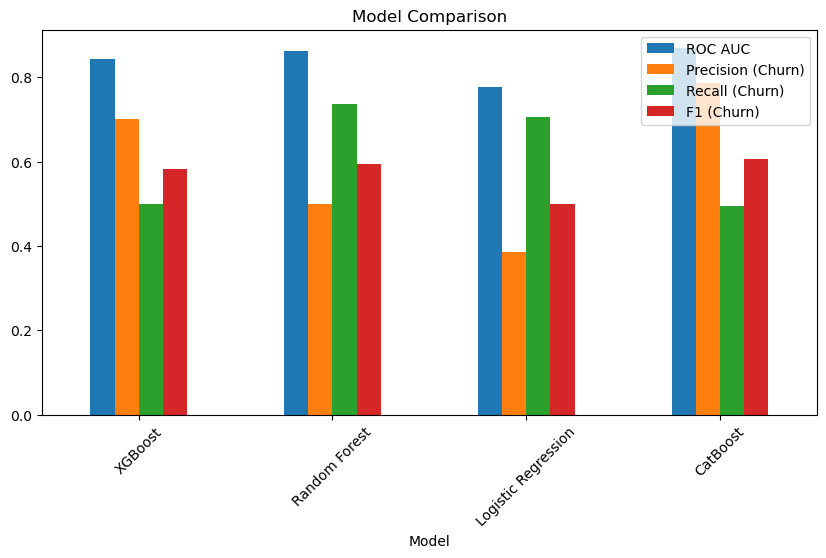

In [41]:
# Simple display
display(results_df)

# Or as a bar plot
results_df.plot(kind='bar', figsize=(10, 5), title='Model Comparison')
plt.xticks(rotation=45)
plt.show()

In [42]:
# 4. SHAP Analysis (For Best Model)
best_model = models[results_df['F1 (Churn)'].idxmax()]
print(f"\nBest Model: {best_model.__class__.__name__}")

# Get predictions from best model
y_train_proba = best_model.predict_proba(X_train)[:, 1]  # Probabilities for class 1 (churn)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Create DataFrames with IDs and probabilities
train_predictions = pd.DataFrame({
    'CustomerId': X_train.index,  # Assuming index is CustomerId
    'churn_prob': y_train_proba,
    'data_type': 'train'
})

test_predictions = pd.DataFrame({
    'CustomerId': X_test.index,
    'churn_prob': y_test_proba,
    'data_type': 'test'
})

# Combine and save
all_predictions = pd.concat([train_predictions, test_predictions])
all_predictions.to_csv("../data/predictions/best_model_predictions.csv", index=False)
print("Saved predictions to ../data/predictions/best_model_predictions.csv")



Best Model: CatBoostClassifier
Saved predictions to ../data/predictions/best_model_predictions.csv


In [43]:
# SHAP values
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)

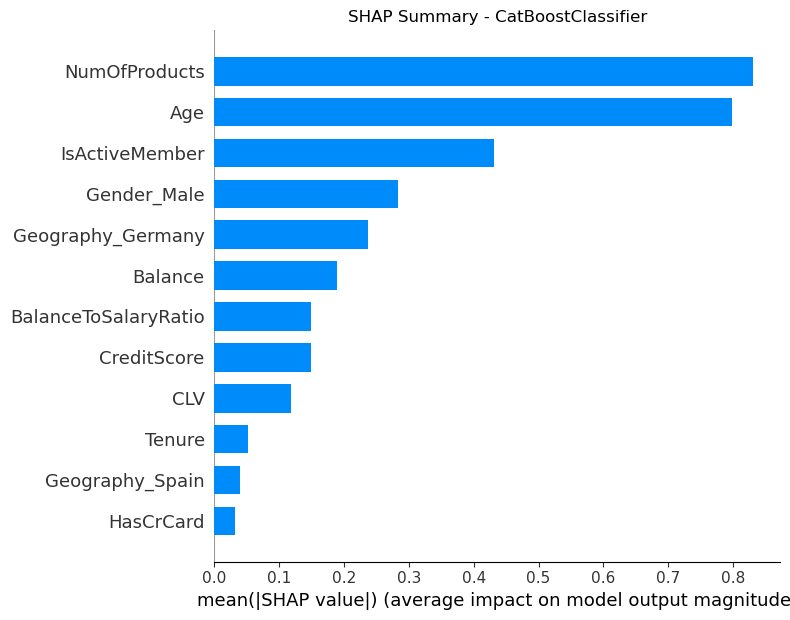

In [44]:
# Summary plot
plt.title(f"SHAP Summary - {best_model.__class__.__name__}")
shap.summary_plot(shap_values, X_train, plot_type="bar")

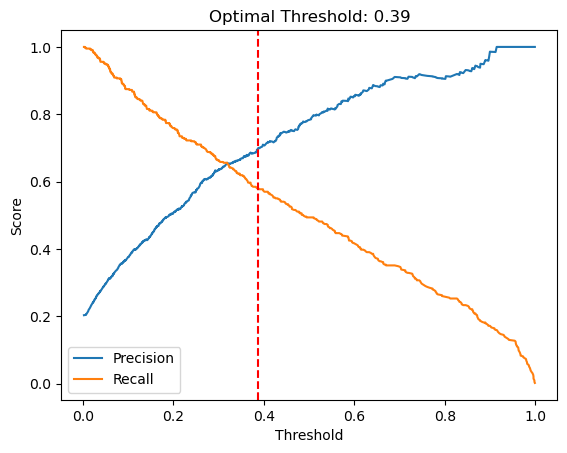

In [45]:
# 5. Threshold Optimization
y_proba = best_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find threshold where precision >= 0.7
optimal_idx = np.argmax(precision >= 0.7)
optimal_threshold = thresholds[optimal_idx]

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(optimal_threshold, color='red', linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title(f"Optimal Threshold: {optimal_threshold:.2f}");

In [46]:
joblib.dump(optimal_threshold, "../models/optimal_threshold.pkl")

['../models/optimal_threshold.pkl']

In [47]:
def plot_classification_matrix(y_true, y_pred, model_name):
    """Plots confusion matrix and prints classification report"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=['Retained', 'Churned'],
        cmap='Blues',
        ax=ax1
    )
    ax1.set_title(f"{model_name} - Confusion Matrix")
    
    # Classification Report
    report = classification_report(
        y_true, y_pred,
        target_names=['Retained', 'Churned'],
        output_dict=True
    )
    report_df = pd.DataFrame(report).transpose()
    report_df.iloc[:2].plot(kind='barh', ax=ax2, colormap='coolwarm')
    ax2.set_title(f"{model_name} - Classification Metrics")
    ax2.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    # Print numerical report
    print(f"\n{classification_report(y_true, y_pred, target_names=['Retained', 'Churned'])}")


XGBoost Performance:


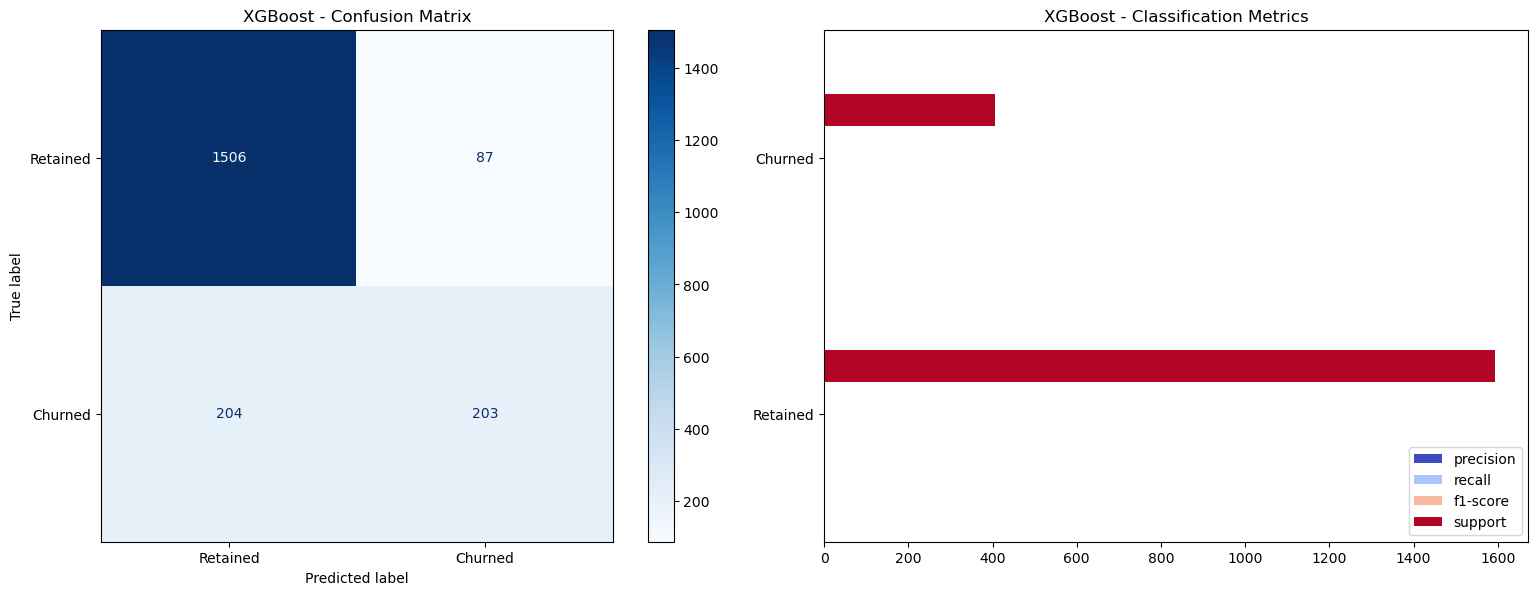


              precision    recall  f1-score   support

    Retained       0.88      0.95      0.91      1593
     Churned       0.70      0.50      0.58       407

    accuracy                           0.85      2000
   macro avg       0.79      0.72      0.75      2000
weighted avg       0.84      0.85      0.84      2000


Random Forest Performance:


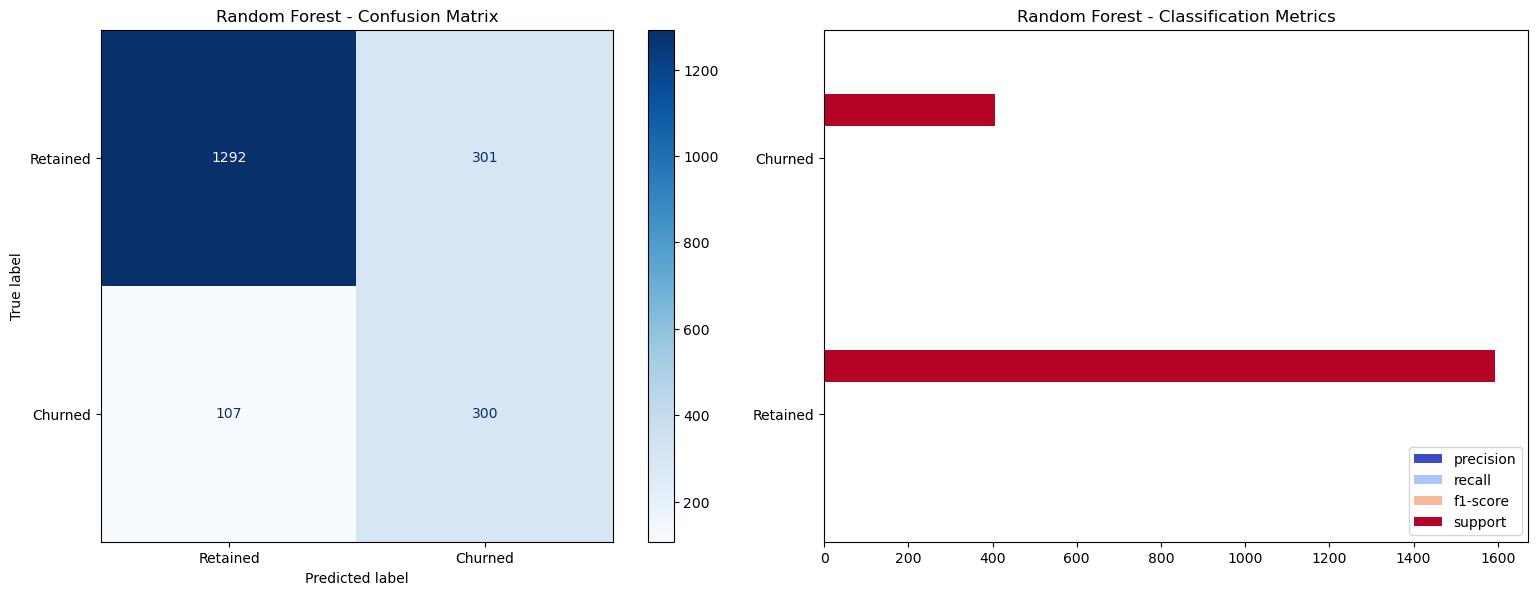


              precision    recall  f1-score   support

    Retained       0.92      0.81      0.86      1593
     Churned       0.50      0.74      0.60       407

    accuracy                           0.80      2000
   macro avg       0.71      0.77      0.73      2000
weighted avg       0.84      0.80      0.81      2000


Logistic Regression Performance:


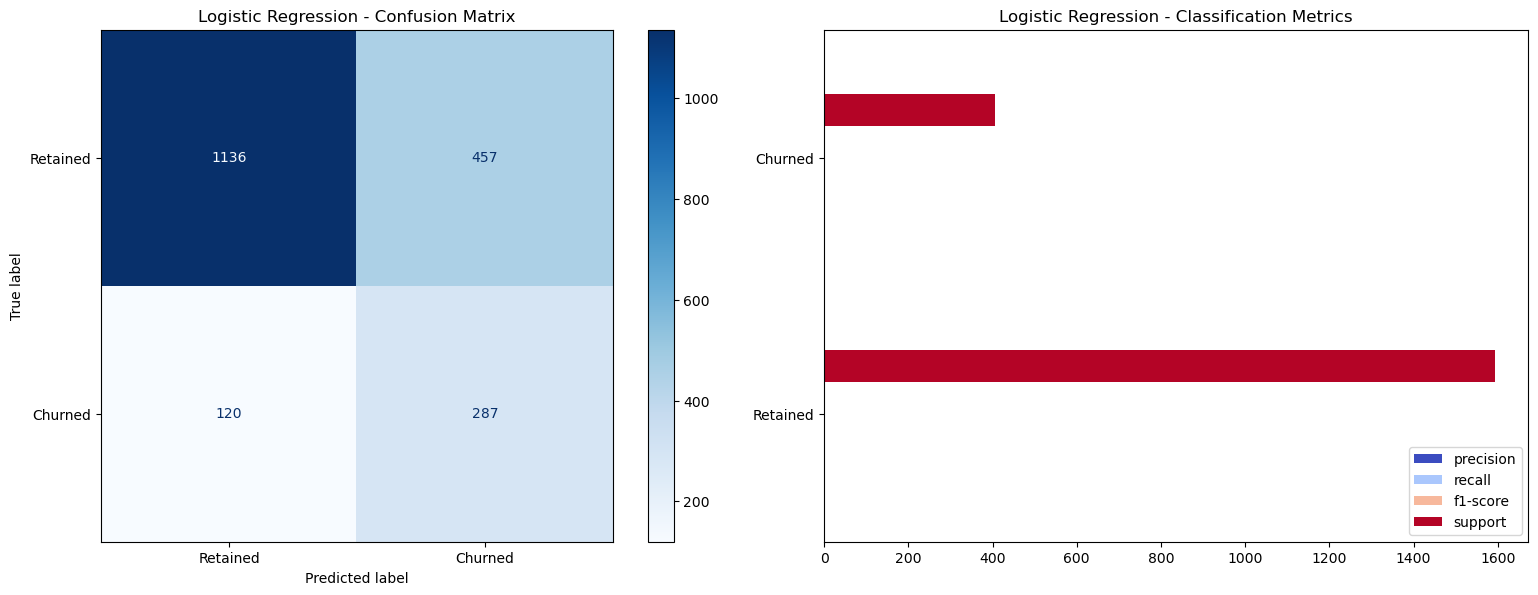


              precision    recall  f1-score   support

    Retained       0.90      0.71      0.80      1593
     Churned       0.39      0.71      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000


CatBoost Performance:


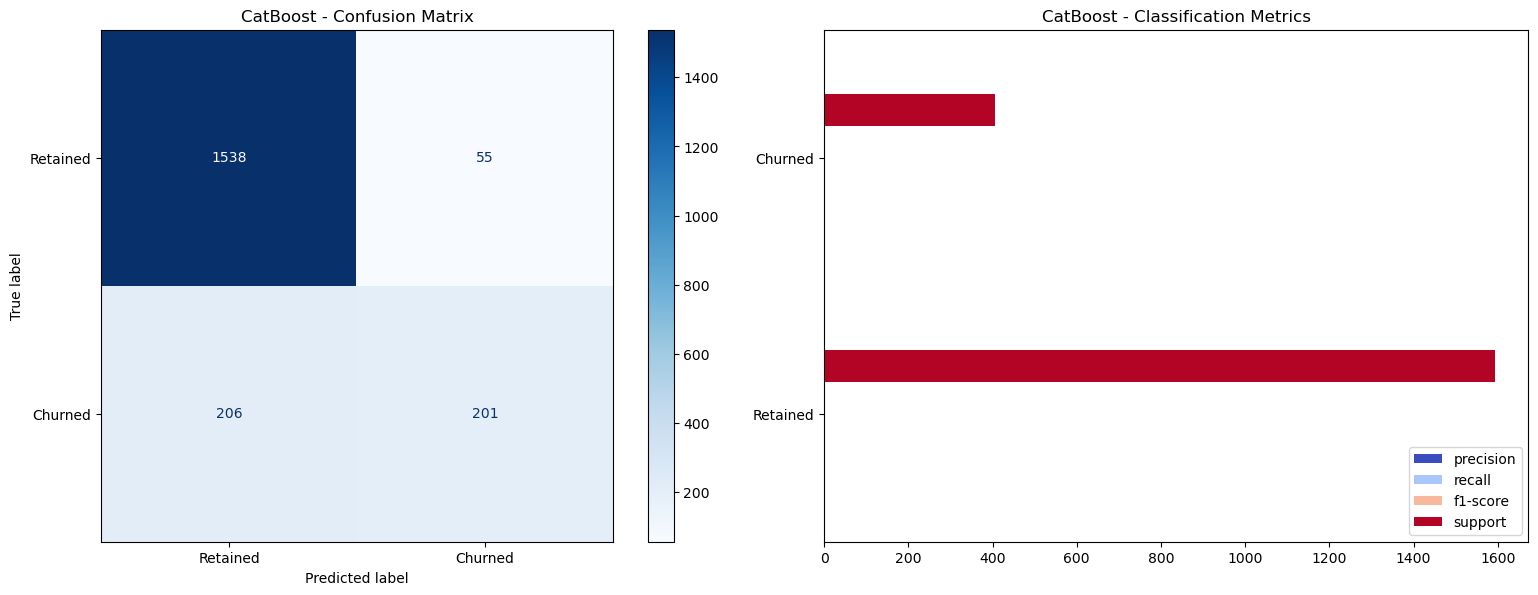


              precision    recall  f1-score   support

    Retained       0.88      0.97      0.92      1593
     Churned       0.79      0.49      0.61       407

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



In [48]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n\033[1m{name} Performance:\033[0m")
    plot_classification_matrix(y_test, y_pred, name)

In [69]:
full_data = X.copy()
full_data['churn_prob'] = best_model.predict_proba(X)[:, 1]
full_data['Churn'] = y  # Add actual target if needed
full_data.to_csv("../data/predictions/data_with_predictions.csv")